# **Introduction**

This homework explores image classification models described in the lecture/textbook. The exercise below repeats the major steps in the dog/cat classification but on a different dataset.

The dataset used for this homework is described in the paper "Food/Non-food Image Classification and Food Categorization using Pre-Trained GoogLeNet Model", Ashutosh Singla, Lin Yuan, Touradj Ebrahimi, MADiMa '16: Proceedings of the 2nd International Workshop on Multimedia Assisted Dietary ManagementOctober 2016 Pages 3–11

Link to the paper: https://dl.acm.org/doi/10.1145/2986035.2986039


# **Dataset**

The official source of this dataset is hosted on EPFl's website but does not seem to be available. Thus we will use the version posted on Kaggle: https://www.kaggle.com/trolukovich/food5k-image-dataset

---

**You must use this specific Kaggle dataset (there are others) and preserve the directory structure of the dataset**

---

You will need to register on Kaggle as described in the textbook on pages 212-213 (or just follow Kaggle instructions).

The dataset contains 2500 food and 2500 non-food images, for the task of food/non-food classification. The whole dataset is divided in three parts: training, validation and evaluation.

Each directory has food/non-food subdirectory containing images of the corresponding class.

---

In the following code cell define the path to the directory containing the dataset. When I'll be running the notebook, I'll modify the path to the directory on my drive.

You also need to define a path to the secret dataset I'll use for additional testing of your models. This dataset will have the same structure:

- root directory
  - food
  - non-food.

The data will be independent of Food-5K. Your code needs to compute the accuracy of food/non-food classification on this dataset. For the sake of development, create the directory structure and copy some images into those directories.


In [1]:
!rm -r ./food5k-image-dataset.zip ./data 
!pip install kaggle
!kaggle datasets download -d trolukovich/food5k-image-dataset
!mkdir ./data
!unzip ./food5k-image-dataset -d ./data -qq

You should consider upgrading via the '/home/max/tmp/homework/venv/bin/python3.9 -m pip install --upgrade pip' command.
100%|████████████████████████████████████████| 426M/426M [00:06<00:00, 75.5MB/s]
100%|████████████████████████████████████████| 426M/426M [00:06<00:00, 69.8MB/s]
Archive:  ./food5k-image-dataset.zip
  inflating: ./data/evaluation/food/0.jpg  
  inflating: ./data/evaluation/food/1.jpg  
  inflating: ./data/evaluation/food/10.jpg  
  inflating: ./data/evaluation/food/100.jpg  
  inflating: ./data/evaluation/food/101.jpg  
  inflating: ./data/evaluation/food/102.jpg  
  inflating: ./data/evaluation/food/103.jpg  
  inflating: ./data/evaluation/food/104.jpg  
  inflating: ./data/evaluation/food/105.jpg  
  inflating: ./data/evaluation/food/106.jpg  
  inflating: ./data/evaluation/food/107.jpg  
  inflating: ./data/evaluation/food/108.jpg  
  inflating: ./data/evaluation/food/109.jpg  
  inflating: ./data/evaluation/food/11.jpg  
  inflating: ./data/evaluation/food/110.jpg

In [1]:
# define the path to the food/non-food dataset
import pathlib

dataset_path = pathlib.Path("./data")
secret_dataset_path = pathlib.Path("./data")


# **Task 1**

In this task you have to design and train a small CNN model following the procedure described in Chapter 8 of the book.

Requirements:

- use at least 256 x 256 image resolution
- do not use exactly the same architecture as in the book, adapt the CNN to match increased image resolution
- (recommendation) in preprocessing, consider preserving the aspect ratio of the original image while scaling
- use data augmentation, add at least one adiditional augmentation method compared to the book (see https://www.tensorflow.org/tutorials/images/data_augmentation)
- add RandomColorDistortion augmentation (see https://towardsdatascience.com/writing-a-custom-data-augmentation-layer-in-keras-2b53e048a98)
- Train the model, display training and validation loss/accuracy curves
- Evaluate the effect of adding dropout layers after convolutional layers. You may try various options (at least one dropout layer/no dropout), evaluate the effect of validation/test accuracy, document the experiment in the report and then keep the best model here.
- **Save the model on the disk** This is your baseline model, everything else is compared to the results obatined by this model.


### Loading The Data


In [ ]:
# create the datasets
from tensorflow.keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (256, 256)

train_dataset = image_dataset_from_directory(
    dataset_path / "training",
    image_size=IMG_SIZE,
    batch_size=64,
    crop_to_aspect_ratio=True,
)
validation_dataset = image_dataset_from_directory(
    dataset_path / "validation",
    image_size=IMG_SIZE,
    batch_size=64,
    crop_to_aspect_ratio=True,
)
test_dataset = image_dataset_from_directory(
    dataset_path / "evaluation",
    image_size=IMG_SIZE,
    batch_size=64,
    crop_to_aspect_ratio=True,
)


Found 3000 files belonging to 2 classes.


2022-03-11 08:39:16.785402: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-11 08:39:17.214564: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


### Creating the Data Augementation Layers


In [6]:
import tensorflow as tf
from tensorflow import keras
import numpy as np


class RandomColorDistortion(keras.layers.Layer):
    def __init__(
        self, contrast_range=[0.9, 1.1], brightness_delta=[-0.1, 0.1], **kwargs
    ):
        super(RandomColorDistortion, self).__init__(**kwargs)
        self.contrast_range = contrast_range
        self.brightness_delta = brightness_delta

    def call(self, images, training=None):
        if not training:
            return images

        contrast = np.random.uniform(self.contrast_range[0], self.contrast_range[1])
        brightness = np.random.uniform(
            self.brightness_delta[0], self.brightness_delta[1]
        )

        images = tf.image.adjust_contrast(images, contrast)
        images = tf.image.adjust_brightness(images, brightness)
        # images = tf.clip_by_value(images, 0, 1)
        return images

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "contrast_range": self.contrast_range,
                "brightness_delta": self.brightness_delta,
            }
        )
        return config


# creating and testing the data augementation
def data_augementation():
    return tf.keras.Sequential(
        [
            tf.keras.layers.RandomTranslation(0.1, 0.1),
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.2),
            RandomColorDistortion(
                contrast_range=[0.8, 1.2], brightness_delta=[-0.1, 0.1]
            ),
        ]
    )


#### Plotting the Augemention Layers


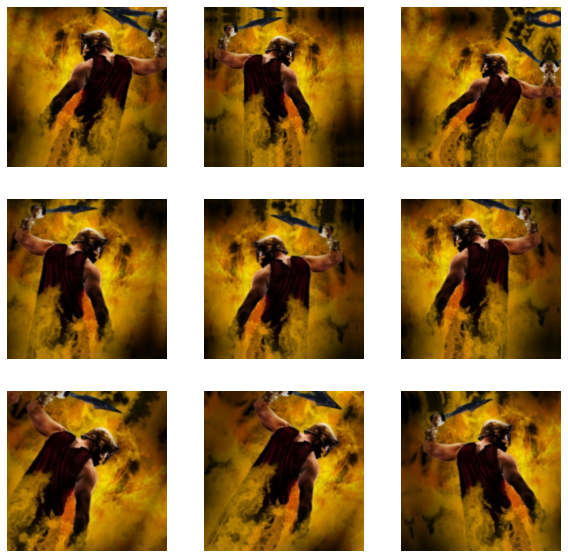

In [5]:
import matplotlib.pyplot as plt

# plotting the data augmentation and the color distortion
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        # augmented_images = RandomColorDistortion(
        #     contrast_range=[0.5, 1.5],
        #     brightness_delta=[-0.2, 0.2]
        # )(images, training=True)
        augmented_images = data_augementation()(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


### Building the Models


In [3]:
from tensorflow import keras
from tensorflow.keras import layers


def build_model(resolution: tuple, dropout_num: int = 0):

    # set the input dimensions
    inputs = keras.Input(shape=(*resolution, 3))

    # add the data augementation
    x = data_augementation()(inputs)

    # rescale the neural net
    x = layers.Rescaling(1.0 / 255)(x)

    # common layers
    dropout_num_t = dropout_num
    for filt in [32, 64, 128, 256]:
        x = layers.Conv2D(filters=filt, kernel=3, activation="relu")(x)
        if dropout_num_t > 1:
            x = layers.Dropout(0.5)(x)
            dropout_num_t -= 1

        x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.Flatten()(x)

    if dropout_num > 0:
        x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    return model


def build_callbacks(save_name):
    return [
        # tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
        keras.callbacks.ModelCheckpoint(
            filepath=save_name, save_best_only=True, monitor="val_loss"
        )
    ]


In [7]:
model = build_model(IMG_SIZE)


### Training the Model


In [8]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=build_callbacks("part_1.keras"),
)


Epoch 1/30


2022-03-10 21:40:56.953330: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-03-10 21:40:57.454539: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-10 21:40:57.456945: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


188/188 [==============================] - 8s 30ms/step - loss: 0.6580 - accuracy: 0.7150 - val_loss: 0.4889 - val_accuracy: 0.8020
Epoch 2/30
188/188 [==============================] - 5s 28ms/step - loss: 0.5115 - accuracy: 0.7787 - val_loss: 0.4004 - val_accuracy: 0.8280
Epoch 3/30
188/188 [==============================] - 5s 28ms/step - loss: 0.4565 - accuracy: 0.8077 - val_loss: 0.4285 - val_accuracy: 0.8170
Epoch 4/30
188/188 [==============================] - 5s 28ms/step - loss: 0.4356 - accuracy: 0.8177 - val_loss: 0.4032 - val_accuracy: 0.8370
Epoch 5/30
188/188 [==============================] - 5s 28ms/step - loss: 0.4231 - accuracy: 0.8260 - val_loss: 0.6297 - val_accuracy: 0.7860
Epoch 6/30
188/188 [==============================] - 5s 27ms/step - loss: 0.3933 - accuracy: 0.8383 - val_loss: 0.5132 - val_accuracy: 0.8280
Epoch 7/30
188/188 [==============================] - 5s 28ms/step - loss: 0.3823 - accuracy: 0.8507 - val_loss: 0.3287 - val_accuracy: 0.8580
Epoch 8/30

### Analyzing the Model


#### Evaluating the Model on Test Set of Data


In [13]:
custom_objects = {
    "RandomColorDistortion": RandomColorDistortion,
}
with keras.utils.custom_object_scope(custom_objects):
    test_model = keras.models.load_model("part_1.keras")

test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

baseline_accuracy = test_acc


2022-03-11 08:40:40.714049: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302


  9/125 [=>............................] - ETA: 0s - loss: 0.2512 - accuracy: 0.9028  

2022-03-11 08:40:41.197336: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-11 08:40:41.199768: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


125/125 [==============================] - 2s 7ms/step - loss: 0.2831 - accuracy: 0.8930
Test accuracy: 0.893


#### Plotting the Training Loss v. Epoch


In [68]:
import matplotlib.pyplot as plt


def plot_history(h):
    acc = h.history["accuracy"]
    val_acc = h.history["val_accuracy"]
    loss = h.history["loss"]
    val_loss = h.history["val_loss"]
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, "bo", label="Training accuracy")
    plt.plot(epochs, val_acc, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()


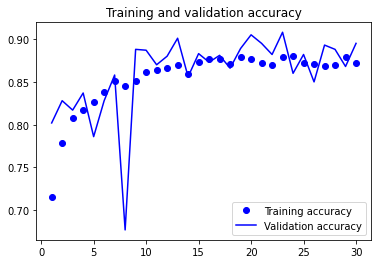

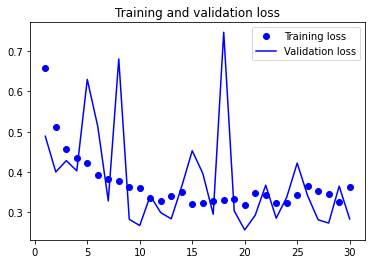

In [11]:
plot_history(history)


### Trying Different Dropouts


In [12]:
for drop_out in range(0, 4):
    _model = build_model(IMG_SIZE, drop_out)
    # Training for just 10 epochs based on plots above
    _model.fit(train_dataset, epochs=30, validation_data=validation_dataset, verbose=0)
    test_loss, test_acc = _model.evaluate(test_dataset)
    print(f"Dropout Layers: {drop_out} accuracy: {test_acc:.3f}")


63/63 [==============================] - 1s 13ms/step - loss: 0.3871 - accuracy: 0.8640
Dropout Layers: 0 accuracy: 0.864
63/63 [==============================] - 1s 13ms/step - loss: 0.6972 - accuracy: 0.8600
Dropout Layers: 1 accuracy: 0.860
63/63 [==============================] - 1s 12ms/step - loss: 0.4526 - accuracy: 0.8680
Dropout Layers: 2 accuracy: 0.868
63/63 [==============================] - 1s 13ms/step - loss: 0.3711 - accuracy: 0.8540
Dropout Layers: 3 accuracy: 0.854


The best results came from two dropout layers. Retraining and saving the model with one dropout layer below


In [13]:
build_model(IMG_SIZE, dropout_num=2).fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    verbose=2,
    callbacks=build_callbacks("part_1.best.keras"),
)


Epoch 1/30
188/188 - 7s - loss: 0.7016 - accuracy: 0.6763 - val_loss: 0.5100 - val_accuracy: 0.7970 - 7s/epoch - 37ms/step
Epoch 2/30
188/188 - 6s - loss: 0.5307 - accuracy: 0.7700 - val_loss: 0.4530 - val_accuracy: 0.8120 - 6s/epoch - 30ms/step
Epoch 3/30
188/188 - 6s - loss: 0.4998 - accuracy: 0.7857 - val_loss: 0.4194 - val_accuracy: 0.8270 - 6s/epoch - 30ms/step
Epoch 4/30
188/188 - 6s - loss: 0.4558 - accuracy: 0.8110 - val_loss: 0.3769 - val_accuracy: 0.8470 - 6s/epoch - 30ms/step
Epoch 5/30
188/188 - 6s - loss: 0.4424 - accuracy: 0.8197 - val_loss: 0.3898 - val_accuracy: 0.8310 - 6s/epoch - 30ms/step
Epoch 6/30
188/188 - 6s - loss: 0.4179 - accuracy: 0.8170 - val_loss: 0.3698 - val_accuracy: 0.8460 - 6s/epoch - 30ms/step
Epoch 7/30
188/188 - 6s - loss: 0.3916 - accuracy: 0.8340 - val_loss: 0.3725 - val_accuracy: 0.8420 - 6s/epoch - 29ms/step
Epoch 8/30
188/188 - 6s - loss: 0.4094 - accuracy: 0.8453 - val_loss: 0.3166 - val_accuracy: 0.8720 - 6s/epoch - 30ms/step
Epoch 9/30
188/1

# **Task 2**

- Load the model from the disk (required so that I can test without retraining)
- Assess accuracy on the test set
- Assess accuracy on the secret dataset (I'll use your code but my own dataset here, do not forget to use `secret_dataset_path`)
- In the report comment on the architecture choices you made, effect of drop out layers.


### Loading the Model


In [14]:
# your solution goes here
custom_objects = {
    "RandomColorDistortion": RandomColorDistortion,
}
with keras.utils.custom_object_scope(custom_objects):
    best_model = keras.models.load_model("part_1.best.keras")


### Assess accuracy on the test set


In [15]:
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


63/63 [==============================] - 1s 13ms/step - loss: 0.3107 - accuracy: 0.8740
Test accuracy: 0.874


### Assess accuracy on the secret dataset


In [16]:
secret_test_dataset = image_dataset_from_directory(
    secret_dataset_path / "evaluation",
    image_size=IMG_SIZE,
    batch_size=32,
    crop_to_aspect_ratio=True,
)

test_loss, test_acc = best_model.evaluate(secret_test_dataset)
print(f"Secret test accuracy: {test_acc:.3f}")


Found 1000 files belonging to 2 classes.
32/32 [==============================] - 1s 22ms/step - loss: 0.3107 - accuracy: 0.8740
Secret test accuracy: 0.874


# **Task 3**

Here you need to use RESNET layers to perform the same classification task.

Requirements:

- double the number of convolution layers compared to the CNN model above (double the depth)
- train for a number of epochs (sufficiently long to match or beat the baseline)
- Replace the CNN layers by RESNET layers, train for the same number of epochs. Note the accuracy and training/validation curves. If needed train until matching/beating the baseline performance.
- **Save the model on the disk**


### Doubling the # of Conv Layers


In [54]:
def build_model_3(
    resolution,
    dropout_num=2,
):
    # set the input dimensions
    inputs = keras.Input(shape=(*resolution, 3))

    # add the data augementation
    x = data_augementation()(inputs)

    # # rescale the neural net
    x = layers.Rescaling(1.0 / 255)(x)

    # common layers
    dropout_num_t = dropout_num
    # add double the layers
    layer_filts = [32, 32, 64, 64, 128, 128, 256, 256,] 
    for i, filt in enumerate(layer_filts):
        x = layers.Conv2D(
            filters=filt, kernel=3, activation="relu", padding="same"
        )(x)
        if dropout_num_t > 1:
            x = layers.Dropout(0.5)(x)
            dropout_num_t -= 1
        if i < len(layer_filts) - 1:
            x = layers.MaxPooling2D(pool_size=2)(x)
    

    x = layers.Flatten()(x)

    if dropout_num > 0:
        x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    return model


### Training the Model


In [11]:
class HaltCallback(tf.keras.callbacks.Callback):
    def __init__(
        self,
        stop_baseline,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        self._stop_baseline = stop_baseline

    def on_epoch_end(self, epoch, logs={}):
        if logs.get("val_accuracy") >= self._stop_baseline:
            self.model.stop_training = True



In [ ]:

history = build_model_3(IMG_SIZE, dropout_num=2).fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,  
    verbose=1,
    callbacks=HaltCallback(baseline_accuracy),
)


In [19]:
print("Double the convolutional layers achieved same validation accuracy in ", 30 - len(history.history["accuracy"]), "less epochs")

Double the convolutional layers achieved same validation accuracy in  13 less epochs


### Replace the CNN with ResNet Layers


In [64]:
from tensorflow import keras
from tensorflow.keras.layers import (
    Conv2D,
    ReLU,
    BatchNormalization,
    Add,
    Flatten,
    MaxPool2D,
    Dense,
    Dropout,
    GlobalAvgPool2D
)


def conv_batchnorm_relu(x, filters, kernel, strides=1):
    x = Conv2D(
        filters=filters, kernel_size=kernel, strides=strides, padding="same"
    )(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    return x


def i_block(tensor, filters):

    x = conv_batchnorm_relu(tensor, filters=filters, kernel=1, strides=1)
    x = conv_batchnorm_relu(x, filters=filters, kernel=3, strides=1)
    x = Conv2D(filters=4 * filters, kernel_size=1, strides=1)(
        x
    )  
    x = BatchNormalization()(x)

    x = Add()([tensor, x])
    x = ReLU()(x)

    return x


def p_block(tensor, filters, strides):
    # left stream
    x = conv_batchnorm_relu(tensor, filters=filters, kernel=1, strides=strides)
    x = conv_batchnorm_relu(x, filters=filters, kernel=3, strides=1)
    x = Conv2D(filters=4 * filters, kernel_size=1, strides=1)(x)
    x = BatchNormalization()(x)

    # right stream
    shortcut = Conv2D(filters=4 * filters, kernel_size=1, strides=strides)(tensor)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([shortcut, x])  # skip connection
    x = ReLU()(x)

    return x


def resnet_chunk(x, filters, reps, strides):
    x = p_block(x, filters, strides)
    for _ in range(reps - 1):
        x = i_block(x, filters)
    return x


def create_resnet(resolution):
    # Creating the Model
    tf.keras.backend.clear_session()

    inputs = keras.Input(shape=(*resolution, 3))

    # add the data augementation
    x = data_augementation()(inputs)
    x = conv_batchnorm_relu(x, filters=64, kernel=8, strides=2)
    x = MaxPool2D(pool_size=3, strides=2)(x)

    x = resnet_chunk(x, filters=32, reps=2, strides=1)
    x = resnet_chunk(x, filters=32 * 2, reps=6, strides=2)
    x = resnet_chunk(x, filters=64 * 2 * 2, reps=6, strides=2)
    
    x = GlobalAvgPool2D()(x)

    x = Flatten()(x)
    # x = Dense(256)(x)
    # x = Dropout(0.8)(x)
    # trying softmax for binary classification
    outputs = Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(), metrics=["accuracy"])
    return model


In [65]:
model = create_resnet(IMG_SIZE)
# model.summary()


In [66]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    verbose=1,
    callbacks=[keras.callbacks.ModelCheckpoint(
        filepath="task3.best.keras", save_best_only=True, monitor="val_loss"
    ),
    HaltCallback(baseline_accuracy)
    ]
)


Epoch 1/100
375/375 [==============================] - 22s 47ms/step - loss: 0.8236 - accuracy: 0.6670 - val_loss: 0.5802 - val_accuracy: 0.7700
Epoch 2/100
375/375 [==============================] - 17s 44ms/step - loss: 0.5296 - accuracy: 0.7557 - val_loss: 0.5855 - val_accuracy: 0.7730
Epoch 3/100
375/375 [==============================] - 17s 44ms/step - loss: 0.5259 - accuracy: 0.7650 - val_loss: 0.7515 - val_accuracy: 0.6900
Epoch 4/100
375/375 [==============================] - 17s 44ms/step - loss: 0.4361 - accuracy: 0.8090 - val_loss: 2.1007 - val_accuracy: 0.5090
Epoch 5/100
375/375 [==============================] - 17s 45ms/step - loss: 0.4523 - accuracy: 0.7960 - val_loss: 0.5646 - val_accuracy: 0.7360
Epoch 6/100
375/375 [==============================] - 17s 45ms/step - loss: 0.4159 - accuracy: 0.8220 - val_loss: 0.4256 - val_accuracy: 0.8280
Epoch 7/100
375/375 [==============================] - 16s 44ms/step - loss: 0.4101 - accuracy: 0.8227 - val_loss: 1.4579 - val_ac

### Plotting the Training


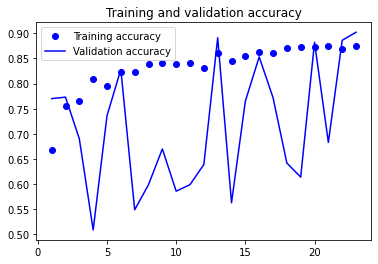

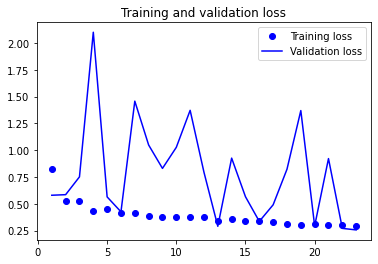

In [69]:
plot_history(history)


# **Task 4**

- Load the model from the disk (required so that I can test without retraining)
- Assess accuracy on the test set
- Assess accuracy on the secret dataset (I'll use your code but my own dataset here, do not forget to use `secret_dataset_path`)
- In the report comment the effects of RESNET layers on convergence speed, accuracy, etc.


### Loading the Model from the Disk


In [70]:
custom_objects = {
    "RandomColorDistortion": RandomColorDistortion,
}
with keras.utils.custom_object_scope(custom_objects):
    best_model = keras.models.load_model("task3.best.keras")


### Assesing the Accuracy on the Test Set


In [71]:

test_loss, test_acc = best_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


125/125 [==============================] - 2s 13ms/step - loss: 0.3153 - accuracy: 0.8670
Test accuracy: 0.867


### Assesing the Accuracy on the Secret Dataset


In [20]:

secret_test_dataset = image_dataset_from_directory(
    secret_dataset_path / "evaluation",
    image_size=IMG_SIZE,
    batch_size=32,
    crop_to_aspect_ratio=True,
)

test_loss, test_acc = best_model.evaluate(secret_test_dataset)
print(f"Secret test accuracy: {test_acc:.3f}")


Found 1000 files belonging to 2 classes.
32/32 [==============================] - 2s 53ms/step - loss: 0.2329 - accuracy: 0.8870
Secret test accuracy: 0.887


# **Task 5**

Here you need to leverage CNN layers of a pre-trained model to perform the same classification task.

Requirements:

- use any pre-trained Keras model except VGG16, VGG19, RESNET-50
- as a source of the models you may use https://keras.io/api/applications/ or any other source on the web
- train the classification layer using any of the two approaches described in the book, display training and validation curves
- **Save the model on the disk**


In [27]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

def create_base():
    conv_base = InceptionResNetV2(
        include_top=False,
        input_shape=(*IMG_SIZE, 3),
        weights="imagenet",
        pooling="avg"
    )
    conv_base.trainable = False

    return conv_base


def create_pretrained(resolution):
    # Creating the Model
    inputs = keras.Input(shape=(*resolution, 3))

    # add the data augementation
    x = data_augementation()(inputs)
    x = preprocess_input(x)
    x = create_base()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    model.compile(loss="binary_crossentropy",
                optimizer="rmsprop",
                metrics=["accuracy"])

    return model

In [28]:
model = create_pretrained(IMG_SIZE)

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10),
        keras.callbacks.ModelCheckpoint(
            filepath="task5.best.keras", save_best_only=True, monitor="val_loss"
        ),
    ],
)


Epoch 1/100
188/188 [==============================] - 28s 110ms/step - loss: 0.3275 - accuracy: 0.9430 - val_loss: 0.1093 - val_accuracy: 0.9810
Epoch 2/100
188/188 [==============================] - 17s 88ms/step - loss: 0.1768 - accuracy: 0.9720 - val_loss: 0.1473 - val_accuracy: 0.9830
Epoch 3/100
188/188 [==============================] - 17s 88ms/step - loss: 0.1996 - accuracy: 0.9700 - val_loss: 0.1451 - val_accuracy: 0.9800
Epoch 4/100
188/188 [==============================] - 18s 94ms/step - loss: 0.1624 - accuracy: 0.9747 - val_loss: 0.1093 - val_accuracy: 0.9860
Epoch 5/100
188/188 [==============================] - 17s 88ms/step - loss: 0.1598 - accuracy: 0.9757 - val_loss: 0.1763 - val_accuracy: 0.9790
Epoch 6/100
188/188 [==============================] - 17s 89ms/step - loss: 0.1765 - accuracy: 0.9777 - val_loss: 0.1414 - val_accuracy: 0.9850
Epoch 7/100
188/188 [==============================] - 17s 88ms/step - loss: 0.1771 - accuracy: 0.9753 - val_loss: 0.1431 - val_a

### Plotting the Training & Validation

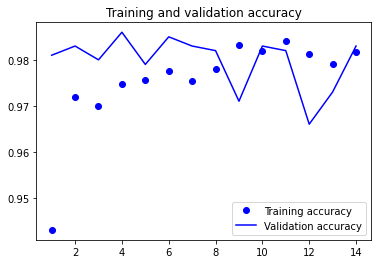

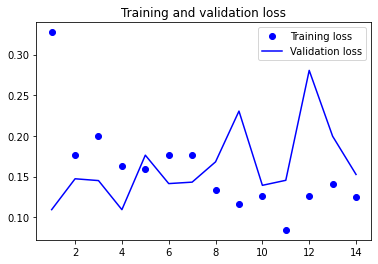

In [29]:
plot_history(history)

# **Task 6**

- Load the model from the disk (required so that I can test without retraining)
- Assess accuracy on the test set
- Assess accuracy on the secret dataset (I'll use your code but my own dataset here, do not forget to use `secret_dataset_path`)
- In the report, comment on the effect of using the pretrained model on speed of convergence, accuracy, etc.


### Load the Model

In [72]:
custom_objects = {
    "RandomColorDistortion": RandomColorDistortion,
}
with keras.utils.custom_object_scope(custom_objects):
    best_model = keras.models.load_model("task5.best.keras")


### Assessing the accuracy on the test set

In [73]:
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

125/125 [==============================] - 8s 44ms/step - loss: 0.0164 - accuracy: 0.9930
Test accuracy: 0.993


### Assessing the accuracy on the secret test set

In [ ]:
secret_test_dataset = image_dataset_from_directory(
    secret_dataset_path / "evaluation",
    image_size=IMG_SIZE,
    batch_size=32,
    crop_to_aspect_ratio=True,
)


test_loss, test_acc = best_model.evaluate(secret_test_dataset)
print(f"Secret test accuracy: {test_acc:.3f}")

# **Grading**

- (10 pts) Report quality / submission requirement followed (see class policy)
- (90 pts) Equally split between Task 1 - Task 6, accounting for correcteness of the approach and satifaction of the requirements above
- (10 pts) Beat the paper accuracy on the secret dataset


# **Report** (your report goes here, keep the length manageable)

Report may also be submitted as a pdf document in the same compressed folder.

- Introduction
- Methods
- Results
- Discussion/Conclusions


## Introduction

Homework 3 asked us to explore image classification models that the textboook presents in Chapter 8. The models were applied to a dataset of food and non-food images from "Food/Non-food Image Classification and Food Categorization using Pre-Trained GoogLeNet Model" (citated in the Introduction). The dataset contains 5000 images in total, 2500 of which are non-food and 2500 food. 

Four different classification models were ultimately applied to the dataset. The first model applied to the dateset was a simple convolutional neural network (CNN) from the book. The second was the same convolutional neural network as before, except it had double the depth of the first. In addition to the two CNNs, a ResNet model was built using the Keras functional API and applied to the dataset. Finally, a pretrained model from Keras called the InceptionResNetV2 was used applied to the data. The validation accuracy and training time of all four models was recorded and will be presented below.

## Methods

Before the image classification models could be applied to the training set, we were asked to add several data augmentation layers. Data augmentation serves to increase the variabilty of the dataset and helps combat overfitting. In fact, with data augmentation the classification model will never "see" exactly the same image during training, as each has some amount of random variation applied. For this assignment, I applied four types of augmentation: random translation, random flip, random rotation, random zoom, and a custom color distortion layer. The effects of the augmentation can be seen in the figure in Section Task 1->Plotting the Augemention Layers, where the augmentation is applied to a random image 9 different times. The data augmentation layers were added sequentially after the input layer of each of the four models.

The first two classification models came directly from the book. Because the images in this assignment had a different resolution than the book's, we had to change the dimensions of the CNNs input layer to match the food image resolution. Part 1 asked us to analyze the effect of dropout layers on training & validation. I wrote a simple for loop to look at the effects of adding 1-3 dropout layers. I added a callback function to the training that saved the best model during model training. The subsequently saved models were then used in validation.

Part 3 asked us to double the depth of the CNN from Part 1, which was done using the functional API. Because it only wanted us to train the model for "up to" the classification accuracy of the simpler CNN (our "baseline" accuracy), I wrote a callback class that stopped training as soon as the validation accuracy achieved the accuracy of the CNN in Part 1. Part 3 also asked us to build a comparably sized ResNet and the code to build the ResNet is presented in Task 3. 

In Part 5, a pretrained model was extended to work with the food classification dataset. The pretrained model (InceptionResNetV2) functioned as the untrainable core and the data augmenation layers as well as two Dense layers were added to the output.

After training each of the four models, their accuracy was analyzed by applying the best model during training to the test dataset.

## Results

Below are presentated the results from training and validating the 4 classification models in this assignment. The GPU used for training is a Linux server with a NVIDIA GeForce RTX 2080 Ti, 64 CPU cores and 500Gb of RAM.

By applying the CNN from the book in Part 1, I was able to achieve a classification accuracy of 89.3% when it was applied to the test set. The training was relatively quick, averaging around 5s per epoch or 28ms/step. Adding dropout layers did not increase the classification accuracy significantly, but two dropout layers did lead to the best validation results.

In Part 3, the depth of the CNN from Part 1 was doubled. Doubling the depth of the CNN did not increase the training time measurably, with the training still taking ~ 5s per epoch or 27ms/step. Doubling the depth did allow the CNN to acheive a validation accuracy equivalent to that in Part 1 in ~half the training epochs. After looking at the effect of depth on the CNN, a similiarly sized ResNet was applied. The ResNet took longer to trai train at 16s per epoch or 44ms/step. It acheived the baseline classification accuracy in 23 training epochs.

Using a pre-trained model in Part 5 was very efficient. The pretrained model was able to beat the validation accuracy of the baseline from the very first training epoch. Each training epoch took 17s or 89ms/step. The pre-trained model converged on a steady-state validation accuracy of ~98% in just 14 epochs. When tested on the test set, it had an accuracy of 99.3%

## Discussion / Conclusions

This assignment asked us to 

# **Submission**

Using Blackboard, submit the .ipynb file and **saved models** in a compressed folder as defined by the class policy.


# **Hints**

The code from chapter 8 is posted here: https://github.com/fchollet/deep-learning-with-python-notebooks

The code needs minimal changes to run the very first approximation of the solution. Once that is operational, proceed to satisfy all assignment requirements.
